In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
import torch
import os
from deep_KG_learning import Net 

Using PyTorch Version 1.8.1


In [2]:
### Loading trained network ### 

script_dir = os.path.dirname('deep_KO_learning.py') # getting relative path
trained_models_path = os.path.join(script_dir, 'trained_models') # which relative path do you want to see
data_path = os.path.join(script_dir,'data/')

netsize_dir = trained_models_path + '/slow_manifold_KG_netsize.pickle' # contains the shape of network
net_dir = trained_models_path+'/slow_manifold_KG_net.pt' # contains params of network

NUM_INPUTS,NUM_OUTPUTS,HL_SIZES = pickle.load(open(netsize_dir,'rb'))

model = Net(NUM_INPUTS,NUM_OUTPUTS,HL_SIZES)
model.load_state_dict(torch.load(net_dir))
model.eval();

In [3]:
### Loading corresponding dataset ###

# Datasets
file_dir = 'slow_manifold_KG.p' 
# file_dir = 'toggle_switch_KG.p'

def get_snapshot_matrices(X,nT,nTraj): 
    '''This function assumes the global snapshot matrix is constructed with trajectories 
        sequentially placed in the columns'''
    prevInds = [x for x in range(0,nT-1)]
    forInds = [x for x in range(1,nT)]
    for i in range(0,nTraj-1):
        if i == 0:
            more_prevInds = [x + nT for x in prevInds]
            more_forInds = [x + nT for x in forInds]
        else: 
            more_prevInds = [x + nT for x in more_prevInds]
            more_forInds = [x + nT for x in more_forInds]
        prevInds = prevInds + more_prevInds
        forInds = forInds + more_forInds
    Xp = X[:,prevInds]
    Xf = X[:,forInds]
    return Xp,Xf

X,nT,nTraj,dt_list = pickle.load(open(data_path+file_dir,'rb'))
Xp,Xf = get_snapshot_matrices(X,nT,nTraj)
trainXp = torch.Tensor(Xp.T)
trainXf = torch.Tensor(Xf.T)
testX = torch.Tensor(X.T)

numDatapoints = nT*nTraj # number of total snapshots

print('Dimension of the state: ' + str(trainXp.shape[1]));
print('Number of trajectories: ' + str(nTraj));
print('Number of total snapshots: ' + str(nT*nTraj));

Dimension of the state: 2
Number of trajectories: 80
Number of total snapshots: 8000


In [4]:
def pred(net,Xp,Xf,nObs,dt_list,step='N'):
    '''This function computes the models 1-step or N-step prediction, N being the number of snapshots in each trajectory'''

    # net: the pytorch model class
    # Xp and Xp: the snapshot matrices
    # nObs: number of observables in the model
    # dt_list: list of timesteps 
    
    PsiXf = net(Xf) # the truth 
    KPsiXp = torch.zeros(Xp.shape[0],nObs)
#     pinvV = torch.pinverse(net.V)

    if step == 'N':
        
        for i in range(0,Xp.shape[0],nT-1):
            KPsiXp[i,:] = net(Xf[i:i+1])
        for i in range(1,Xp.shape[0]):
            dt = dt_list[i]
            K = torch.matrix_exp(net.Lgen*dt)
#             eL = torch.diag_embed(torch.exp(net.L*dt)) 
#             K = torch.matmul(torch.matmul(net.V,eL),pinvV)
            if i not in range(0,Xp.shape[0],nT-1):
                KPsiXp[i,:] = torch.matmul(net(KPsiXp[i-1:i,1:Xp.shape[1]+1]),K) 
        
    if step == '1': 
        
        for i in range(0,trainXp.shape[0]):
            dt = dt_list[i]
            K = torch.matrix_exp(net.Lgen*dt)
#             eL = torch.diag_embed(torch.exp(net.L*dt)) # exponential of the eigs, then embedded into a diagonal matrix
#             K = torch.matmul(torch.matmul(net.V,eL),pinvV) # matrix representation of Koopman operator
            KPsiXp[i,:] = torch.matmul(net(Xp[i:i+1]),K)  
            
    return KPsiXp, PsiXf
        
def plotPred(Xfpred,Xf,dimState,traj,tspan,step):
    plt.rcParams.update({'font.size':14})
    plt.figure();
    for i in range(1,dimState+1):
        plt.plot(tspan[1:],Xfpred[traj*(nT-1):traj*(nT-1)+nT-1,i].detach().numpy(),'s-',lw=2,ms=4,color='tab:blue');
        plt.plot(tspan[1:],Xf[traj*(nT-1):traj*(nT-1)+nT-1,i].detach().numpy(),'o-',lw=2,ms=4,color='tab:orange');
    plt.legend(['Predicted','Truth']);
    plt.ylabel(r'$\mathbf{x}$');
    plt.title(r'$'+step+'$-step prediction')
    plt.xlabel(r'$t$');
    

In [5]:
KPsiXpN, PsiXfN = pred(model,trainXp,trainXf,NUM_OUTPUTS,dt_list,step='N')
KPsiXp1, PsiXf1 = pred(model,trainXp,trainXf,NUM_OUTPUTS,dt_list,step='1')


In [6]:
# recovering the tSpan that was used to sample the data. 
tSpan = np.zeros(nT)
tSpan[0] = 0
for i in range(1,len(tSpan)):
    tSpan[i] = tSpan[i-1] + dt_list[i-1] 

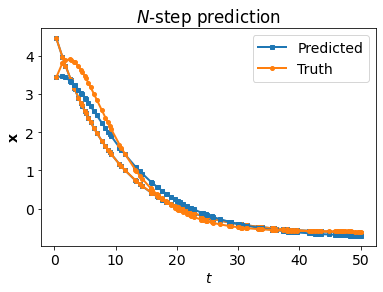

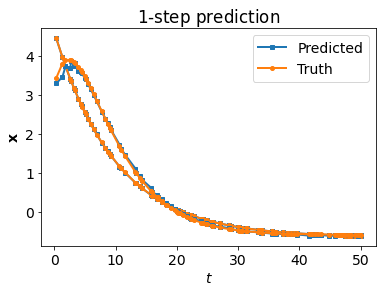

In [26]:
traj = np.random.randint(0,nTraj)
plotPred(KPsiXpN,PsiXfN,trainXp.shape[1],traj,tSpan,'N')
plotPred(KPsiXp1,PsiXf1,trainXp.shape[1],traj,tSpan,'1')

In [ ]:
eVals = np.linalg.eigvals(model.Lgen.detach().numpy())
plt.plot(np.real(eVals),np.imag(eVals),'o');
plt.vlines(0.0,-4,4,color='black',alpha=0.75);
plt.hlines(0.0,np.min(np.real(eVals)),np.max(np.real(eVals)),color='black',alpha=0.75);
